Create a virtual environment for Python to run in:

`$ python3.8 -m venv .venv`

Activate the virtual environment

`$ source .venv/bin/activate`

Update pip and setuptools

`$ pip install --upgrade pip setuptools`

Install requirements

`$ pip install -r requirements.txt`


# Research

The initial goal is to determine the different variables that we can change to see how effieiency changes.
As of now, these are:
- GPU Frequency (14)
- CPU Frequency
- Memory Frequency
- Matrix Size (128 to 2048, with steps of 128) (16)
- Deep Learning Accelerators (DLAs)
- Tensor Cores (2)
- Data Types (Half, Float, Double) (3)

Ideally the goal would be to test all combinations of them, but as there are over 30,000 combinations it's unreasonable.

For the tests I chose to do all 14 of the GPU frequencies, Matrix sizes from 128 to 2048 with steps of 128 (16 total tests), with and without tensor cores, for 3 data tytpes (Half, Float, and Double). This gives 1344 tests.

## AGX Info

```
$ cat /etc/nv_tegra_release 
# R32 (release), REVISION: 4.4, GCID: 23942405, BOARD: t186ref, EABI: aarch64, DATE: Fri Oct 16 19:37:08 UTC 2020
```

```
$ nvcc -V
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Wed_Oct_23_21:14:42_PDT_2019
Cuda compilation tools, release 10.2, V10.2.89
```

## Nano Info
Todo

The `benchmark.cu` file is used for benchmarking the Jetson boards using various options.

Before each test, the CPU min/max frequency is set to it's maximum frequency (can also be changed later for more power usage info).

```
$ echo "2265600" | sudo tee /sys/devices/system/cpu/cpu0/cpufreq/scaling_{min,max}_freq
```

The GPU frequency is then set

AGX
```
$ echo "1377000000" | sudo tee /sys/devices/17000000.gv11b/devfreq/17000000.gv11b/{min,max}_freq
```

Nano
```
$ todo
```

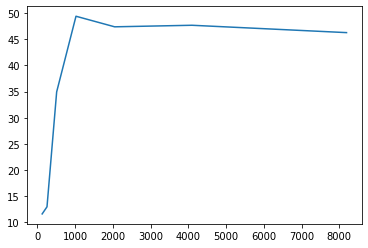

In [19]:
import os
import matplotlib.pyplot as plt

path = "./data/AGX/"
files = os.listdir(path)

search = "float"

x = []
y = []

for file_name in [f for f in files if search in f]:
    # Split filename into components
    device, datatype, m_size = file_name.split(".")[0].split("-")
    x.append(int(m_size))

    with open(path+file_name, "r") as f:
        lines = [l.strip() for l in f.readlines()]
        # FLOPS are on the last line
        flops = float(lines[-1])
        temp_lines = [map(float, l.split(",")) for l in lines[:-1]]
        ts, watts = zip(*temp_lines)
        avg_watts = sum(watts) / len(watts)
        y.append(avg_watts)

fig, ax = plt.subplots()
# Put data in correct order
x, y = zip(*sorted(zip(x, y)))
ax.plot(x, y)
plt.draw()
        